In [1]:
!pip install opencv-python

In [2]:
!pip install pillow

In [57]:
import numpy as np
import cv2
from PIL import Image
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [63]:
SIZE = 10
EPISODES = 30000
SHOW_EVERY = 3000

FOOD_REWARD = 25
ENEMY_PENALITY = 300
MOVE_PENALITY = 1

epsilon = 0.6
EPS_DECAY = 0.9998
DISCOUNT = 0.95
LEARNING_RATE = 0.1

q_table = 'qtable_1636204341.pickle'

d = {1:(255,0,0), #blue
     2:(0,255,0), #green
     3:(0,0,255)} #red

PLAYER_N = 1
FOOD_N =2
ENEMY_N =3

In [64]:
class Cube:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
        
    def __str__(self):
        return f'{self.x},{self.y}'
    
    def __sub__(self,other):
        return (self.x-other.x,self.y-other.y)
    
    def action(self,choise):
        if choise == 0 :
            self.move(x=1, y=1)
        elif choise == 1 :
            self.move(x=-1, y=1)
        elif choise == 2 :
            self.move(x=1, y=-1)
        elif choise == 3 :
            self.move(x=-1, y=-1)
    
    def move(self,x=False,y=False):
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
            
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y   
            
        if self.x < 0 :
            self.x = 0
        elif self.x >= SIZE :
            self.x = SIZE -1

        if self.y < 0 :
            self.y = 0
        elif self.y >= SIZE :
            self.y = SIZE -1

In [65]:
if q_table is None:
    q_table = {}
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1,y1),(x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]
else:
    with open(q_table,'rb') as f:
        q_table=pickle.load(f)

episode #0, epsilon:0.6
mean reward:nan


/Users/liangsy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/liangsy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode #3000, epsilon:0.32926722239570905
mean reward:-32.624
episode #6000, epsilon:0.18069483957364205
mean reward:-12.621666666666666
episode #9000, epsilon:0.09916147987941909
mean reward:-9.519333333333334
episode #12000, epsilon:0.054417708414240505
mean reward:-9.794333333333332
episode #15000, epsilon:0.029863279497827713
mean reward:-8.415666666666667
episode #18000, epsilon:0.016388331819794114
mean reward:-6.570666666666667
episode #21000, epsilon:0.00899356749667138
mean reward:-4.325666666666667
episode #24000, epsilon:0.00493547831509555
mean reward:-3.7876666666666665
episode #27000, epsilon:0.0027084853933429503
mean reward:-2.073
27001


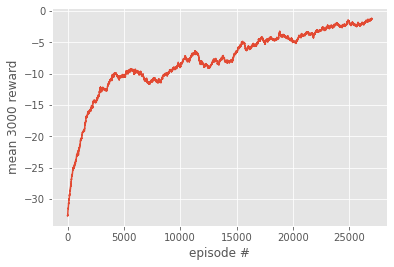

In [66]:
episode_rewards = []
for episode in range(EPISODES):
    player = Cube()
    food = Cube()
    enemy = Cube()

    if episode%SHOW_EVERY == 0 :
        print(f'episode #{episode}, epsilon:{epsilon}')
        print(f'mean reward:{np.mean(episode_rewards[-SHOW_EVERY:])}')
        show = True
    else:
        show = False
    
    episode_reward = 0
    for i in range(200):
        obs = (player-food, player-enemy)
        if np.random.random() > epsilon :
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,4)
        
        player.action(action)
#         food.move()
#         enemy.move()
        
        if player.x == food.x and player.y == food.y :
            reward = FOOD_REWARD
        elif player.x == enemy.x and player.y == enemy.y :
            reward = -ENEMY_PENALITY
        else:
            reward = -MOVE_PENALITY
            
        
        #Update the Q_table
        current_q = q_table[obs][action]
        new_obs =  (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])                
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward+DISCOUNT*max_future_q)        
        q_table[obs][action] = new_q
        
        if show:
            env = np.zeros((SIZE,SIZE,3), dtype=np.uint8)
            env[food.x][food.y] = d[FOOD_N]
            env[player.x][player.y] = d[PLAYER_N]
            env[enemy.x][enemy.y] = d[ENEMY_N]
            img = Image.fromarray(env,'RGB')
            img = img.resize((800,800))
            cv2.imshow('',np.array(img))
            if reward == FOOD_REWARD or reward == -ENEMY_PENALITY:
                if cv2.waitKey(500) & 0xFF == ord('q') :
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q') :
                    break
                   
        episode_reward += reward
        
        if reward == FOOD_REWARD or reward == -ENEMY_PENALITY:
            break
    
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards,np.ones((SHOW_EVERY,))/SHOW_EVERY,mode='valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))],moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()

with open(f'qtable_{int(time.time())}.pickle','wb') as f:
    pickle.dump(q_table,f)

In [56]:
with open(f'qtable_{int(time.time())}.pickle','wb') as f:
    pickle.dump(q_table,f)

27001


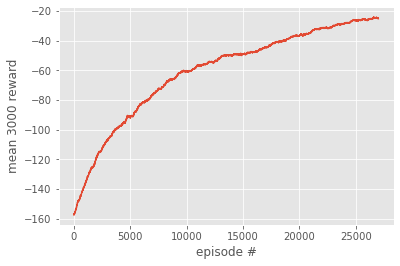

In [55]:
moving_avg = np.convolve(episode_rewards,np.ones((SHOW_EVERY,))/SHOW_EVERY,mode='valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))],moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()

In [50]:
conv = np.convolve([3,8,10,9,11,23,44,55,57,48],np.ones((3,))/3,mode='valid')
print(conv)

[ 7.          9.         10.         14.33333333 26.         40.66666667
 52.         53.33333333]


In [53]:
np.mean([10,9,11])

10.0

In [41]:
food = Cube()
player = Cube()
enemy = Cube()

env = np.zeros((SIZE,SIZE,3), dtype=np.uint8)
env[food.x][food.y] = d[FOOD_N]
env[player.x][player.y] = d[PLAYER_N]
env[enemy.x][enemy.y] = d[ENEMY_N]

img = Image.fromarray(env,'RGB')
img = img.resize((800,800))

cv2.imshow('',np.array(img))

if cv2.waitKey(500) & 0xFF == ord('q') :
    pass


In [6]:
print(len(q_table))

130321


In [8]:
19**4

130321

In [9]:
print(q_table[((1,3),(-2,-4))])

[-2.7773554618819225, -3.563705005054187, -2.2330000919778783, -2.4506302861658162]


In [26]:
player = Cube()
print(player)
player.action(0)
print(player)

7,4
8,5


In [3]:
d[FOOD_N]

(0, 255, 0)